# A 60 Minute Blitz
## Training an image classifier

1. load and normalizing the CIFAR10
2. Define a CNN
3. Define a loss function
4. Train the network on the trainig data
5. Test the network on the test data

## 1. Loading and normalizing CIFAR10

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
# tensorにRGBの各チャンネルを[0,1]を[-1,1]に変更
# 意味ある？

# データの前処理
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# DatasetLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Files already downloaded and verified


In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

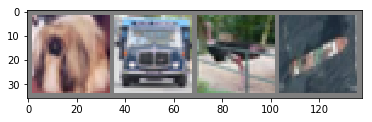

dog   truck bird  ship 


In [70]:
def imshow (img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    # [-1,1]を[0,1]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('{:<5}'.format(classes[labels[j]]) for j in range(4)))

## Define a CNN

In [30]:
import torch.nn as nn
import torch.nn.functional as F

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)  

In [50]:
net.parameters()

<generator object Module.parameters at 0x1180b5b88>

## Define a Loss function and optimizer

In [33]:
import torch.optim as optim

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [90]:
# batch_size 4
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 勾配をゼロ初期化決まりごと？
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ更新
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[{}, {}] loss: {:.3}'.format(epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')            

[1, 2000] loss: 2.31
[1, 4000] loss: 2.31
[1, 6000] loss: 2.31
[1, 8000] loss: 2.31
[1, 10000] loss: 2.31
[1, 12000] loss: 2.31
[2, 2000] loss: 2.31
[2, 4000] loss: 2.31
[2, 6000] loss: 2.31
[2, 8000] loss: 2.31
[2, 10000] loss: 2.31
[2, 12000] loss: 2.31
Finished Training


## Test the network on the test data

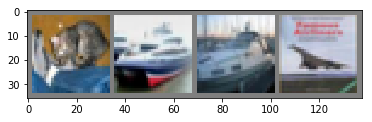

GroudTruth:    cat  ship  ship plane


In [52]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroudTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [61]:
outputs = net(images)
values, labels = torch.max(outputs, 1)
print('Predicted : ', ' '.join('{:<5}'.format(classes[labels[j]]) for j in range(4)))

Predicted :    cat   car  ship  ship


## 全テストデータのaccuracy

In [73]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # 出力ラベル
        _, predicted = torch.max(outputs.data, 1)
        # batchサイズを足してく
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: {}%'.format(100 * correct/total))        

Accuracy of the network on the 10000 test images: 59.95%


## カテゴリごとのaccuracy

In [87]:
# floatの要素
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # 出力ラベル
        _, predicted = torch.max(outputs, 1)
        # 無駄な次元取る
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
for i in range(10):
    print('Accuracy of {}: {}%'.format(classes[i], 100 * class_correct[i]/class_total[i]))        

Accuracy of plane: 63.8%
Accuracy of car: 80.2%
Accuracy of bird: 32.5%
Accuracy of cat: 43.6%
Accuracy of deer: 46.2%
Accuracy of dog: 37.3%
Accuracy of frog: 77.8%
Accuracy of horse: 77.8%
Accuracy of ship: 66.8%
Accuracy of truck: 73.5%


## Option Data Parallelism
- デフォだと1このGPUしか使わないけど、`DataParallel`を使うと2つ以上使える

float